In [24]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.optim as optim
from torchvision import datasets, transforms


from models.simple_LSTM import *
from models.train_model import train
from models.early_stopping import EarlyStopping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [163]:
from data.dummy import DummyDataset
import numpy as np
torch.manual_seed(0)

transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(-262.1078, 31.9126),
        # transforms.Resize([128,128]),
        transforms.Lambda(lambda x : x.squeeze()),
        ])

features_selection = np.arange(6)
dataset = DummyDataset('../data/dataset_pickle', features_selection, transform, max_length=4096)


data processing: 100%|██████████| 94/94 [01:16<00:00,  1.23it/s]


In [164]:
size = int(len(dataset) * 0.9)

train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
print(f'train size : {len(train_set)}, val size : {len(test_set)}')

train size : 84, val size : 10


In [166]:
input_size = dataset[0][0].shape[1]
print(f'input_size={input_size}')
hidden_size = 32
num_layers = 1
lr = 1e-3
weight_decay = 1e-4
l1_sigma = 1e-5

pos_weight = torch.tensor(3.2843)

model = SimpleLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

early_stopping = EarlyStopping(patience=10, delta=5e-2)

print(model)    
print(optimizer)
print(criterion)
print(f'l1_sigma={l1_sigma}')
print(early_stopping)

input_size=6
The model has 5,793 trainable parameters
SimpleLSTM(
  (lstm): LSTM(6, 32, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
BCEWithLogitsLoss()
l1_sigma=1e-05
EarlyStopping(
    patience : 10
    delta : 0.05
)


Epoch 370: 100%|██████████| 3/3 [00:00<00:00, 27.52batch/s, loss=0.222]


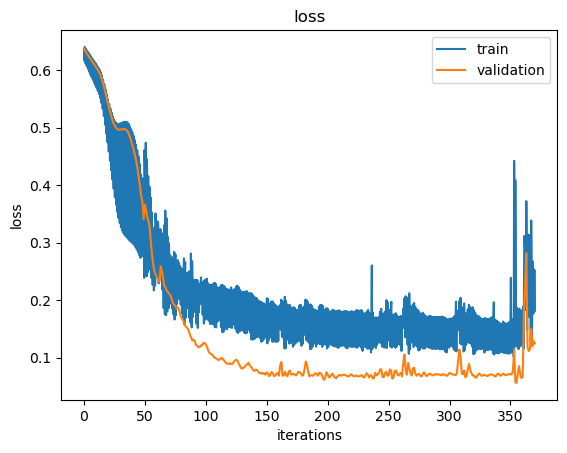

In [167]:
train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      n_epochs=500, 
      l1_sigma = l1_sigma,
      early_stopping=early_stopping)

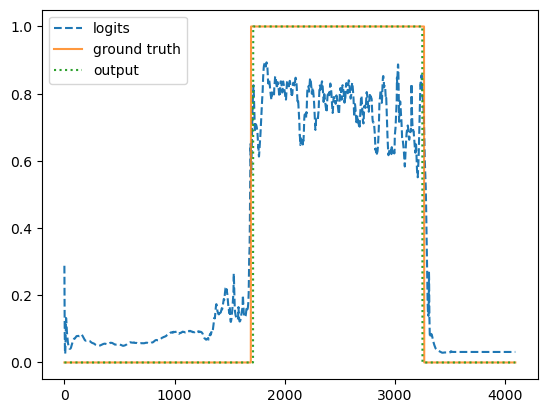

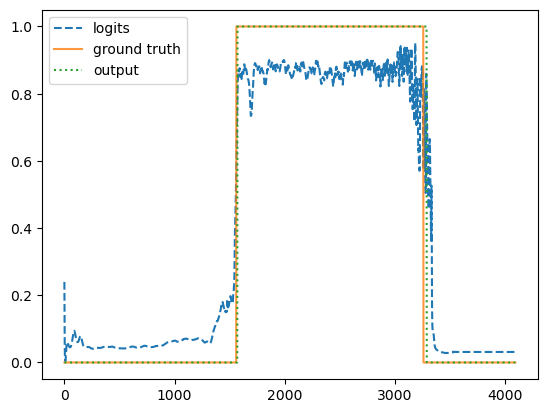

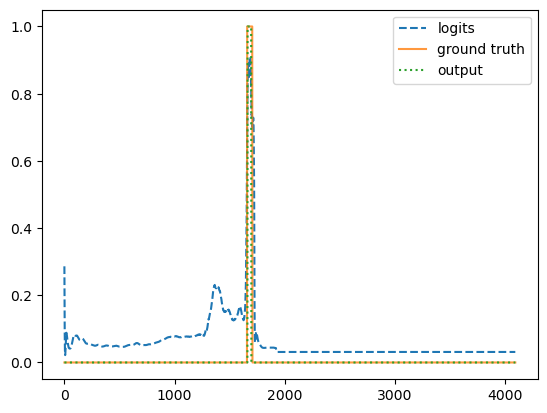

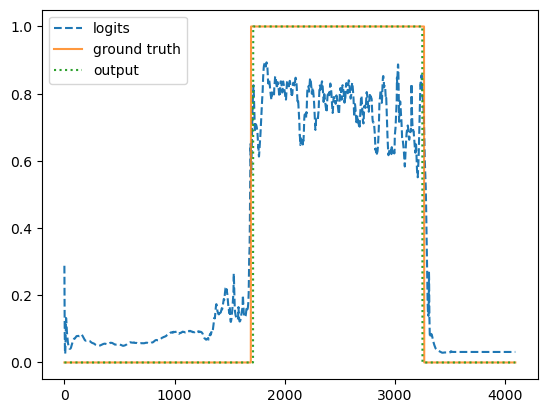

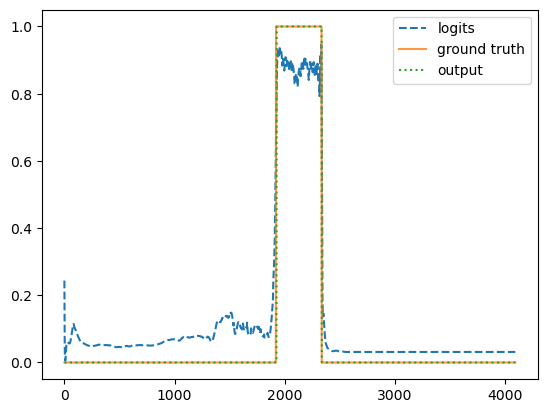

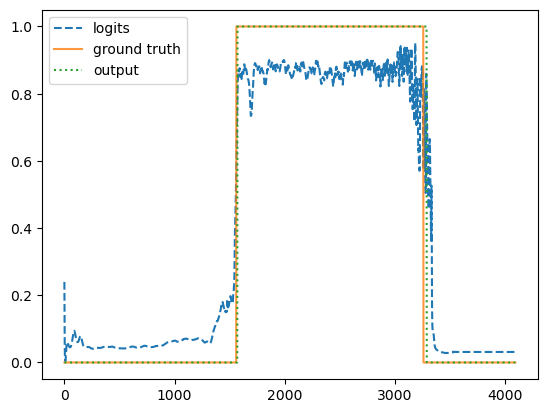

In [169]:
import numpy as np

def create_output(logit, threshold=0.8):
    if (logit < threshold).all():
        return torch.zeros(len(logit))

    start = np.argmax(logit > threshold)
    end = len(logit) - torch.argmax(torch.flip(logit > threshold, dims=(0,)) * 1)

    output = torch.zeros(len(logit))
    output[start:end] = 1

    return output


model.eval()
with torch.no_grad():
    for idx in np.random.choice(len(test_set), 6): 
        testing_data = test_set[idx]
        pred = torch.sigmoid(model(testing_data[0].to(device))).detach().cpu()
        plt.plot(pred.numpy(), label='logits', linestyle='--' )
        plt.plot(testing_data[1], label='ground truth', alpha=0.8)
        plt.plot(create_output(pred), label='output', linestyle=':')
        plt.legend()
        plt.show()